#  Capstone Project - The Battle of Neighborhoods in Hobart

## Part-1 Loading data that contains the information of Hobart

In [1]:
import pandas as pd
import numpy as np

In [2]:
Tas=pd.read_excel('Population Estimates by Statistical Area Level 2.xls',sheet_name="Table 6",skiprows=7)
Tas.dropna(subset=['S/T name'],inplace=True)
Tas.rename(columns={'no..1':'population','km2':'Area (km^2)','persons/km2':'Population density persons/km2'},inplace=True)
Tas=Tas.loc[1:,['S/T name','GCCSA name','SA4 name','SA3 name','SA2 name','population','Area (km^2)','Population density persons/km2']]
Hobart=Tas[Tas['SA4 name']=='Hobart']
Hobart.head()

,S/T name,GCCSA name,SA4 name,SA3 name,SA2 name,population,Area (km^2),Population density persons/km2
1,Tasmania,Greater Hobart,Hobart,Brighton,Bridgewater - Gagebrook,7543.0,55.7,135.3
2,Tasmania,Greater Hobart,Hobart,Brighton,Brighton - Pontville,6213.0,88.8,70.0
3,Tasmania,Greater Hobart,Hobart,Brighton,Old Beach - Otago,4975.0,31.6,157.6
4,Tasmania,Greater Hobart,Hobart,Hobart - North East,Bellerive - Rosny,6092.0,4.7,1291.2
5,Tasmania,Greater Hobart,Hobart,Hobart - North East,Cambridge,8367.0,101.7,82.3


# Part 2: Add Geospatial Data

In [3]:
Location=pd.read_csv('Hobart_Location.csv')
Hobart=pd.merge(Hobart,Location,how='left',on='SA2 name')
Hobart.head()

,S/T name,GCCSA name,SA4 name,SA3 name,SA2 name,population,Area (km^2),Population density persons/km2,Latitude,Longitude
0,Tasmania,Greater Hobart,Hobart,Brighton,Bridgewater - Gagebrook,7543.0,55.7,135.3,-42.742330,147.268999
1,Tasmania,Greater Hobart,Hobart,Brighton,Brighton - Pontville,6213.0,88.8,70.0,-42.690997,147.252832
2,Tasmania,Greater Hobart,Hobart,Brighton,Old Beach - Otago,4975.0,31.6,157.6,-42.800497,147.287999
3,Tasmania,Greater Hobart,Hobart,Hobart - North East,Bellerive - Rosny,6092.0,4.7,1291.2,-42.870663,147.352832
4,Tasmania,Greater Hobart,Hobart,Hobart - North East,Cambridge,8367.0,101.7,82.3,-42.835330,147.437998


## Part-3 Clustering Neighborhoods in Hobart

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### Let's get the geographical coordinates of Hobart

In [5]:
address = 'Hobart'

geolocator = Nominatim(user_agent="Hobart_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hobart are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hobart are -42.8825088, 147.3281233.


#### Let's visualize the neighborhoods in Hobart

In [6]:
# create map of Hobart using latitude and longitude values
map_Hobart = folium.Map(location=[latitude, longitude], zoom_start=10)

 # add markers to map
for lat, lng, label in zip(Hobart['Latitude'], Hobart['Longitude'], Hobart['SA2 name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Hobart) 
    
map_Hobart

#### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

##### Define Foursquare Credentials and Version

In [7]:
# @hidden_cell
CLIENT_ID = 'OKHTI0DDE2ZIJCSYE5Z5TY5NZFBIRRXFMQUI1C1ZWR03PKX5' # your Foursquare ID
CLIENT_SECRET = 'PB0USD430HPWSTUFQVPWARYHUSOFAHIEAYFUYAB214PLT23G' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OKHTI0DDE2ZIJCSYE5Z5TY5NZFBIRRXFMQUI1C1ZWR03PKX5
CLIENT_SECRET:PB0USD430HPWSTUFQVPWARYHUSOFAHIEAYFUYAB214PLT23G


#### Now, let's get the top 100 venues that are in Bridgewater - Gagebrook within a radius of 1000 meters

In [8]:
neighborhood_latitude = Hobart.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Hobart.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Hobart.loc[0, 'SA2 name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bridgewater - Gagebrook are -42.74233036, 147.2689989.


In [9]:
LIMIT = 100

radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=OKHTI0DDE2ZIJCSYE5Z5TY5NZFBIRRXFMQUI1C1ZWR03PKX5&client_secret=PB0USD430HPWSTUFQVPWARYHUSOFAHIEAYFUYAB214PLT23G&v=20180605&ll=-42.74233036,147.2689989&radius=1000&limit=100'

In [10]:
results = requests.get(url).json()

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,IGA X-Press Gagebrook,Supermarket,-42.74869,147.266000
1,MONA Beer & Wine Tastings,Brewery,-42.73640,147.278059


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


In [14]:
print ('{} unique categories in Bridgewater - Gagebrook'.format(nearby_venues['categories'].value_counts().shape[0]))

2 unique categories in Bridgewater - Gagebrook


In [15]:
print (nearby_venues['categories'].value_counts()[0:10])

Supermarket    1
Brewery        1
Name: categories, dtype: int64


#### Explore Neighborhoods in Hobart

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [17]:
Hobart_venues = getNearbyVenues(names=Hobart['SA2 name'],
                                   latitudes=Hobart['Latitude'],
                                   longitudes=Hobart['Longitude']
                                  )

Bridgewater - Gagebrook
Brighton - Pontville
Old Beach - Otago
Bellerive - Rosny
Cambridge
Geilston Bay - Risdon
Howrah - Tranmere
Lindisfarne - Rose Bay
Mornington - Warrane
Risdon Vale
Rokeby
South Arm
Austins Ferry - Granton
Berriedale - Chigwell
Claremont (Tas.)
Derwent Park - Lutana
Glenorchy
Montrose - Rosetta
Moonah
New Norfolk
West Moonah
Kingston - Huntingfield
Kingston Beach - Blackmans Bay
Margate - Snug
Mount Wellington
Taroona - Bonnet Hill
Hobart
Lenah Valley - Mount Stuart
Mount Nelson - Dynnyrne
New Town
Sandy Bay
South Hobart - Fern Tree
West Hobart
Dodges Ferry - Lewisham
Sorell - Richmond


In [18]:
Hobart_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bridgewater - Gagebrook,-42.742330,147.268999,IGA X-Press Gagebrook,-42.748690,147.266000,Supermarket
1,Bridgewater - Gagebrook,-42.742330,147.268999,MONA Beer & Wine Tastings,-42.736400,147.278059,Brewery
2,Brighton - Pontville,-42.690997,147.252832,IGA Everyday Brighton,-42.698300,147.253070,Grocery Store
3,Brighton - Pontville,-42.690997,147.252832,Pontville Park,-42.686827,147.261758,Park
4,Brighton - Pontville,-42.690997,147.252832,Pontville Football Oval,-42.685972,147.261680,Athletics & Sports


In [19]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Hobart_Venues_only_restaurant = Hobart_venues[Hobart_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
Hobart_Venues_only_restaurant.index = np.arange(1, len(Hobart_Venues_only_restaurant )+1)

In [20]:
print (Hobart_Venues_only_restaurant['Venue Category'].value_counts())

Fast Food Restaurant     16
Mexican Restaurant        6
Japanese Restaurant       5
Asian Restaurant          4
Thai Restaurant           4
Indian Restaurant         4
Chinese Restaurant        3
Australian Restaurant     3
Italian Restaurant        2
Sushi Restaurant          1
Portuguese Restaurant     1
Restaurant                1
Indonesian Restaurant     1
French Restaurant         1
Name: Venue Category, dtype: int64


In [21]:
print('There are {} uniques categories.'.format(len(Hobart_Venues_only_restaurant['Venue Category'].unique())))

There are 14 uniques categories.


In [22]:
# create a dataframe of top 10 categories
Hobart_Dist_Venues_Top10 = Hobart_Venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
Hobart_Dist_Venues_Top10=Hobart_Dist_Venues_Top10.reset_index()
#Hobart_5_Dist_Venues_Top10

Hobart_Dist_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Hobart_Dist_Venues_Top10

,Venue_Category,Frequency
0,Fast Food Restaurant,16
1,Mexican Restaurant,6
2,Japanese Restaurant,5
3,Asian Restaurant,4
4,Thai Restaurant,4
5,Indian Restaurant,4
6,Chinese Restaurant,3
7,Australian Restaurant,3
8,Italian Restaurant,2
9,Sushi Restaurant,1


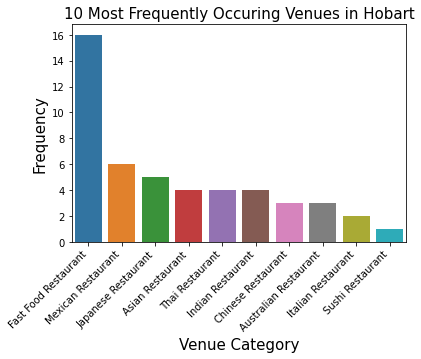

<Figure size 1440x1440 with 0 Axes>

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=Hobart_Dist_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues in Hobart', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("a.jpg",dpi=300, bbox_inches = 'tight')
fig = plt.figure(figsize=(20,20))
plt.show()

#### Let's check the size of the resulting dataframe

In [24]:
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Hobart_Venues_only_restaurant.shape)
Hobart_Venues_only_restaurant.head(10)

Shape of the Data-Frame with Venue Category only Restaurant:  (52, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Cambridge,-42.835330,147.437998,Cambridge Kitchen & Newsagent,-42.837000,147.441220,Fast Food Restaurant
2,Geilston Bay - Risdon,-42.835163,147.350665,Geilston Bay Fish Shop,-42.840350,147.351730,Fast Food Restaurant
3,Lindisfarne - Rose Bay,-42.841997,147.351832,Geilston Bay Fish Shop,-42.840350,147.351730,Fast Food Restaurant
4,Claremont (Tas.),-42.787164,147.252666,KFC,-42.790415,147.254093,Fast Food Restaurant
5,Derwent Park - Lutana,-42.834497,147.287832,KFC,-42.837539,147.287771,Fast Food Restaurant
6,Derwent Park - Lutana,-42.834497,147.287832,McDonald's,-42.841493,147.290928,Fast Food Restaurant
7,Glenorchy,-42.826497,147.272166,Hungry Jack's,-42.831465,147.270292,Fast Food Restaurant
8,Glenorchy,-42.826497,147.272166,KFC,-42.832523,147.274035,Fast Food Restaurant
9,Moonah,-42.839163,147.301165,Kawasemi Japanese Tea House,-42.846274,147.294829,Japanese Restaurant
10,Moonah,-42.839163,147.301165,McDonald's,-42.841493,147.290928,Fast Food Restaurant


In [25]:
Hobart_Venues_restaurant = Hobart_Venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())

#### Analyze Each Neighborhood

In [26]:
Hobart_Venues_restaurant 

Neighborhood
Cambridge                          1
Claremont (Tas.)                   1
Derwent Park - Lutana              2
Geilston Bay - Risdon              1
Glenorchy                          2
Hobart                            13
Kingston Beach - Blackmans Bay     2
Lindisfarne - Rose Bay             1
Margate - Snug                     1
Moonah                             6
New Norfolk                        1
New Town                           1
Sandy Bay                          8
Sorell - Richmond                  4
West Hobart                        1
West Moonah                        7
Name: Venue Category, dtype: int64

In [27]:
Hobart_Venues_restaurant_df  = Hobart_Venues_restaurant.to_frame().reset_index()
Hobart_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
Hobart_Venues_restaurant_df.index = np.arange(1, len(Hobart_Venues_restaurant_df)+1)
list_rest_no =Hobart_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =Hobart_Venues_restaurant_df['Neighborhood'].to_list()

In [28]:
Hobart_onehot = pd.get_dummies(Hobart_Venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")
Hobart_onehot.head(10)

,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Portuguese Restaurant,Restaurant,Sushi Restaurant,Thai Restaurant
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,0,0,0,0
10,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [29]:
# one hot encoding
Hobart_onehot = pd.get_dummies(Hobart_Venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Hobart_onehot['Neighborhood'] = Hobart_Venues_only_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Hobart_onehot.columns[-1]] + list(Hobart_onehot.columns[:-1])
Hobart_onehot = Hobart_onehot[fixed_columns]

Hobart_onehot.head()

,Neighborhood,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Portuguese Restaurant,Restaurant,Sushi Restaurant,Thai Restaurant
1,Cambridge,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Geilston Bay - Risdon,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Lindisfarne - Rose Bay,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Claremont (Tas.),0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Derwent Park - Lutana,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [30]:
# And let's examine the new dataframe size.
Hobart_onehot.shape

(52, 15)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
Hobart_grouped = Hobart_onehot.groupby('Neighborhood').mean().reset_index()
Hobart_grouped.head(10)

,Neighborhood,Asian Restaurant,Australian Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Portuguese Restaurant,Restaurant,Sushi Restaurant,Thai Restaurant
0,Cambridge,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,Claremont (Tas.),0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,Derwent Park - Lutana,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,Geilston Bay - Risdon,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,Glenorchy,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,Hobart,0.153846,0.076923,0.0,0.000000,0.0,0.153846,0.076923,0.076923,0.076923,0.076923,0.076923,0.0,0.076923,0.153846
6,Kingston Beach - Blackmans Bay,0.000000,0.500000,0.0,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,Lindisfarne - Rose Bay,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,Margate - Snug,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,Moonah,0.000000,0.000000,0.0,0.166667,0.0,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.0,0.000000,0.166667


#### Let's confirm the new size

In [32]:
Hobart_grouped.shape

(16, 15)

#### Let's print each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5

for hood in Hobart_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Hobart_grouped[Hobart_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cambridge----
                   venue  freq
0   Fast Food Restaurant   1.0
1       Asian Restaurant   0.0
2  Australian Restaurant   0.0
3     Chinese Restaurant   0.0
4      French Restaurant   0.0


----Claremont (Tas.)----
                   venue  freq
0   Fast Food Restaurant   1.0
1       Asian Restaurant   0.0
2  Australian Restaurant   0.0
3     Chinese Restaurant   0.0
4      French Restaurant   0.0


----Derwent Park - Lutana----
                   venue  freq
0   Fast Food Restaurant   1.0
1       Asian Restaurant   0.0
2  Australian Restaurant   0.0
3     Chinese Restaurant   0.0
4      French Restaurant   0.0


----Geilston Bay - Risdon----
                   venue  freq
0   Fast Food Restaurant   1.0
1       Asian Restaurant   0.0
2  Australian Restaurant   0.0
3     Chinese Restaurant   0.0
4      French Restaurant   0.0


----Glenorchy----
                   venue  freq
0   Fast Food Restaurant   1.0
1       Asian Restaurant   0.0
2  Australian Restaurant   0.0
3  

#### Let's put that into a *pandas* dataframe

In [34]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Hobart_grouped['Neighborhood']

for ind in np.arange(Hobart_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Hobart_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cambridge,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
1,Claremont (Tas.),Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
2,Derwent Park - Lutana,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
3,Geilston Bay - Risdon,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
4,Glenorchy,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
5,Hobart,Thai Restaurant,Indian Restaurant,Asian Restaurant,Sushi Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Australian Restaurant
6,Kingston Beach - Blackmans Bay,Indian Restaurant,Australian Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant
7,Lindisfarne - Rose Bay,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
8,Margate - Snug,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
9,Moonah,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant


## Cluster Neighborhoods

### Run *k*-means to cluster the neighborhood into 5 clusters.

In [36]:
# set number of clusters
kclusters = 5

Hobart_grouped_clustering = Hobart_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Hobart_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 1, 2, 0, 4, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [37]:
flag=pd.Series(kmeans.labels_)
Hobart_grouped['Label']=flag
result=Hobart_grouped[['Neighborhood','Label']]
result

,Neighborhood,Label
0,Cambridge,0
1,Claremont (Tas.),0
2,Derwent Park - Lutana,0
3,Geilston Bay - Risdon,0
4,Glenorchy,0
5,Hobart,1
6,Kingston Beach - Blackmans Bay,2
7,Lindisfarne - Rose Bay,0
8,Margate - Snug,4
9,Moonah,1


In [38]:
final_data=pd.merge(result,neighborhoods_venues_sorted,how='left',on='Neighborhood')
final_data

,Neighborhood,Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cambridge,0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
1,Claremont (Tas.),0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
2,Derwent Park - Lutana,0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
3,Geilston Bay - Risdon,0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
4,Glenorchy,0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
5,Hobart,1,Thai Restaurant,Indian Restaurant,Asian Restaurant,Sushi Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Australian Restaurant
6,Kingston Beach - Blackmans Bay,2,Indian Restaurant,Australian Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant
7,Lindisfarne - Rose Bay,0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
8,Margate - Snug,4,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
9,Moonah,1,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant


In [39]:
# add clustering labels
# merge Hobart_grouped with Hobart_data to add latitude/longitude for each neighborhood
Hobart=pd.DataFrame(Hobart)
Hobart.rename(columns={'SA2 name':'Neighborhood'},inplace=True)
Hobart_merged =pd.merge(final_data,Hobart,how='left',on='Neighborhood')

Hobart_merged.head() # check the last columns!

,Neighborhood,Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,S/T name,GCCSA name,SA4 name,SA3 name,population,Area (km^2),Population density persons/km2,Latitude,Longitude
0,Cambridge,0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,Tasmania,Greater Hobart,Hobart,Hobart - North East,8367.0,101.7,82.3,-42.835330,147.437998
1,Claremont (Tas.),0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,Tasmania,Greater Hobart,Hobart,Hobart - North West,8046.0,17.9,448.9,-42.787164,147.252666
2,Derwent Park - Lutana,0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,Tasmania,Greater Hobart,Hobart,Hobart - North West,4241.0,4.9,862.1,-42.834497,147.287832
3,Geilston Bay - Risdon,0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,Tasmania,Greater Hobart,Hobart,Hobart - North East,3314.0,8.7,380.3,-42.835163,147.350665
4,Glenorchy,0,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,Tasmania,Greater Hobart,Hobart,Hobart - North West,11646.0,10.5,1113.4,-42.826497,147.272166


Finally, let's visualize the resulting clusters

In [40]:
# create map
map_restaurants10 = folium.Map(location=[latitude,longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']
#Districts = ['Nagatacho', 'Nihonbashi', 'Shinjuku', 'Shinagawa', 'Shibuya']

# add markers to the map
for lat, lon, poi, cluster in zip(Hobart_merged['Latitude'], 
                                  Hobart_merged['Longitude'], 
                                  Hobart_merged['Neighborhood'], 
                                  Hobart_merged['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[list_dist.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

## Examine the Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

## Cluster 1

In [41]:
neighborhoods_venues_sorted[result['Label']==0]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cambridge,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
1,Claremont (Tas.),Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
2,Derwent Park - Lutana,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
3,Geilston Bay - Risdon,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
4,Glenorchy,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
7,Lindisfarne - Rose Bay,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
10,New Norfolk,Fast Food Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
13,Sorell - Richmond,Fast Food Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant


## Cluster 2

In [42]:
neighborhoods_venues_sorted[result['Label']==1]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Hobart,Thai Restaurant,Indian Restaurant,Asian Restaurant,Sushi Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Australian Restaurant
9,Moonah,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
12,Sandy Bay,Asian Restaurant,Thai Restaurant,Mexican Restaurant,Italian Restaurant,Indian Restaurant,French Restaurant,Chinese Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant
15,West Moonah,Fast Food Restaurant,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant


## Cluster 3

In [43]:
neighborhoods_venues_sorted[result['Label']==2]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Beach - Blackmans Bay,Indian Restaurant,Australian Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant
11,New Town,Australian Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant


## Cluster 4

In [44]:
neighborhoods_venues_sorted[result['Label']==3]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,West Hobart,Restaurant,Thai Restaurant,Sushi Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant,French Restaurant


## Cluster 5

In [45]:
neighborhoods_venues_sorted[result['Label']==4]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Margate - Snug,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Indonesian Restaurant,Indian Restaurant
